In [1]:
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [17]:
# database connection

conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

In [18]:
# getting data

df = pd.read_sql_query('select * from flats_new', conn)

C:\Users\eliza\AppData\Local\Temp\ipykernel_29852\3829361265.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select * from flats_new', conn)


In [19]:
# general preproccessing

df['price'] = df['price'].apply(price_corr)
df.drop('id', inplace=True, axis=1)
df.drop_duplicates(inplace=True)

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)

df.drop(['warning', 'trash', 'barriers'], inplace=True, axis=1)

df = df.replace('None', np.nan)


df['district'] = df['address'].apply(lambda x: x.split()[4])

df.drop('address', inplace=True, axis=1)

df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['metro'] = df['metro'].isna().apply(lambda x: 'Yes' if x == False  else 'No')

In [20]:
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)

In [26]:
# separating old and new flats

df_new = df[df['year'].isna() == False]
df_old = df[df['year'].isna() == True]

In [27]:
# working with nan values and feature engineering for old flats

df_old = df_old.dropna(subset=['living_sq', 'kitchen_sq'])
df_old.drop(['decor', 'year', 'floor'], axis=1, inplace=True)

df_old['elevators'] = df_old['elevators'].fillna(df_old['elevators'].mode())
df_old['balcony'] = df_old['balcony'].fillna(df_old['balcony'].mode())
df_old['toilets'] = df_old['toilets'].fillna(df_old['toilets'].mode()[0])
df_old['window_view'] = df_old['window_view'].fillna(df_old['window_view'].mode()[0])
df_old['ceil_height'] = df_old['ceil_height'].fillna(df_old['ceil_height'].mode()[0])
df_old['entrance'] = df_old['entrance'].fillna(df_old['entrance'].mode()[0])
df_old['ceil_height'] = df_old['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df_old['toilets_united'] = df_old['toilets'].apply(toilet_single)
df_old['toilets_sep'] = df_old['toilets'].apply(toilet_not_sngl)
df_old.drop('toilets', axis=1, inplace=True)

df_old['big_elev'] = df_old['elevators'].apply(big_elevators)
df_old['little_elev'] = df_old['elevators'].apply(lit_elevators)
df_old.drop('elevators', axis=1, inplace=True)

df_old['balcon'] = df_old['balcony'].apply(lambda x: int(x.split()[0]) if 'балкон' in x else 0)
df_old['lodgia'] = df_old['balcony'].apply(lambda x: int(x.split()[0]) if 'лоджия' in x else 0)
df_old.drop('balcony', axis=1, inplace=True)

df_old['warm'] = df_old['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)

df_old_dummy = pd.get_dummies(df_old, columns=['rented', 'metro', 'window_view', 'home_type', 'warm', 'district'], dtype = 'float64')

TypeError: argument of type 'float' is not iterable

In [58]:
df_new = df_new.dropna(subset=['living_sq', 'kitchen_sq'])
df_new.drop(['decor', 'year', 'floor', 'entrance', 'toilets', 'balcony', 'rented', 'window_view'], axis=1, inplace=True)

df_new['elevators'] = df_new['elevators'].fillna(df_new['elevators'].mode()[0])

df_new['ceil_height'] = df_new['ceil_height'].fillna(df_new['ceil_height'].mode()[0])

df_new['ceil_height'] = df_new['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df_new['big_elev'] = df_new['elevators'].apply(big_elevators)
df_new['little_elev'] = df_new['elevators'].apply(lit_elevators)
df_new.drop('elevators', axis=1, inplace=True)

df_new['warm'] = df_new['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)
df_new.drop_duplicates()

df_new_dummy = pd.get_dummies(df_new, columns=['home_type', 'warm', 'district', 'metro'], dtype = 'float64')

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

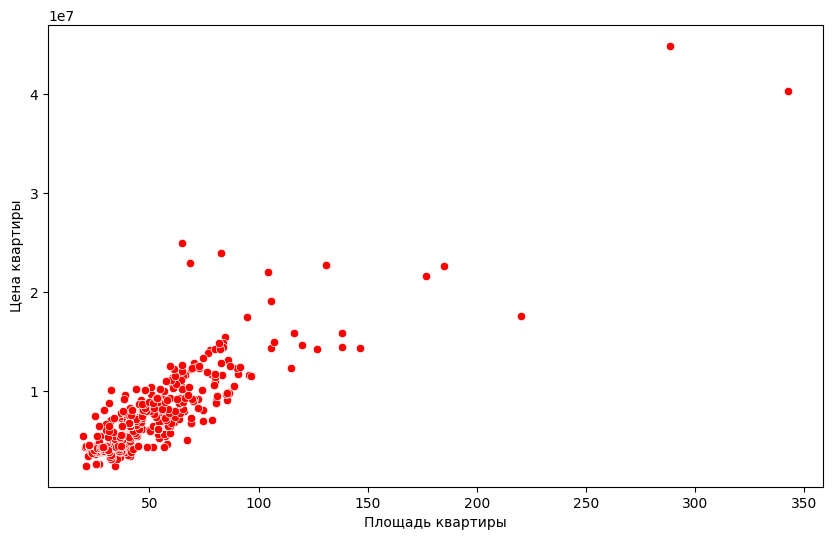

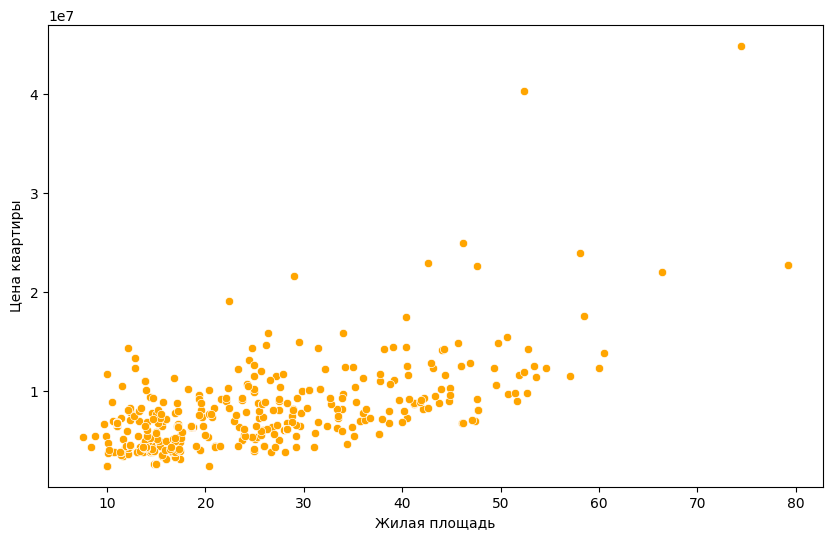

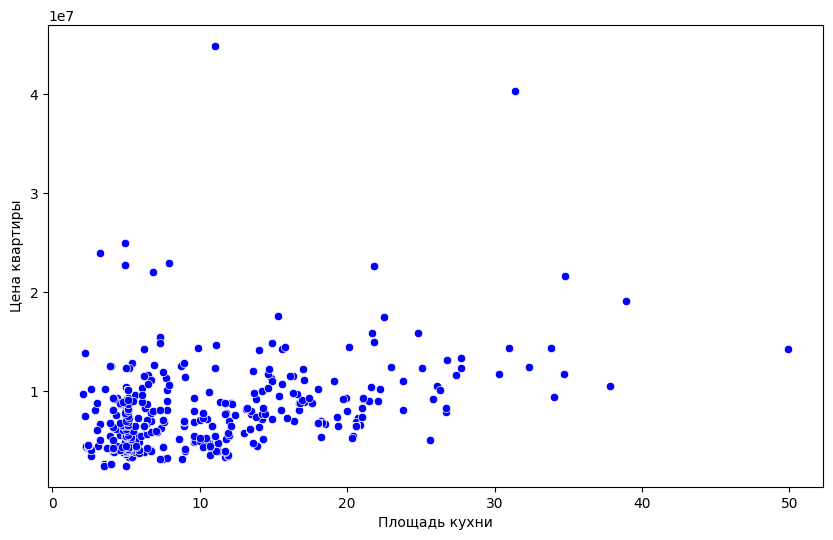

In [9]:
#EDA (new flats)

plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_new_dummy['total_square'], y=df_new_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_new_dummy['living_sq'], y=df_new_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_new_dummy['kitchen_sq'], y=df_new_dummy['price'], color='blue')

<Axes: xlabel='price', ylabel='Density'>

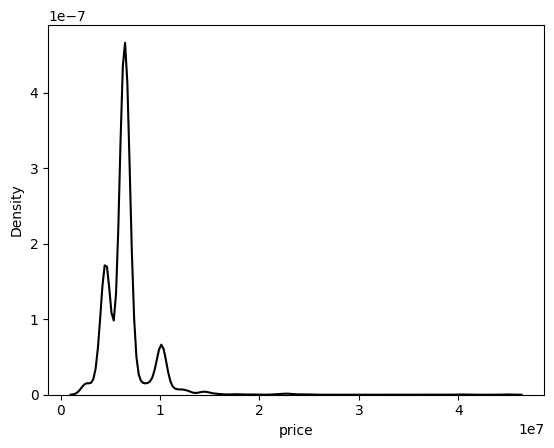

In [10]:
sns.kdeplot(df_new['price'], color='black')

<Axes: xlabel='total_square', ylabel='Density'>

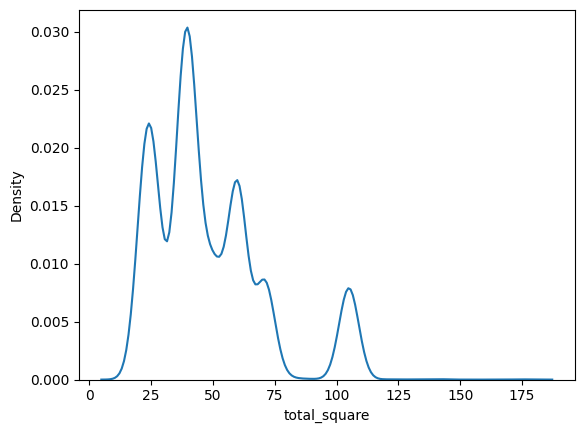

In [11]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Район', ylabel='Количестов квартир'>

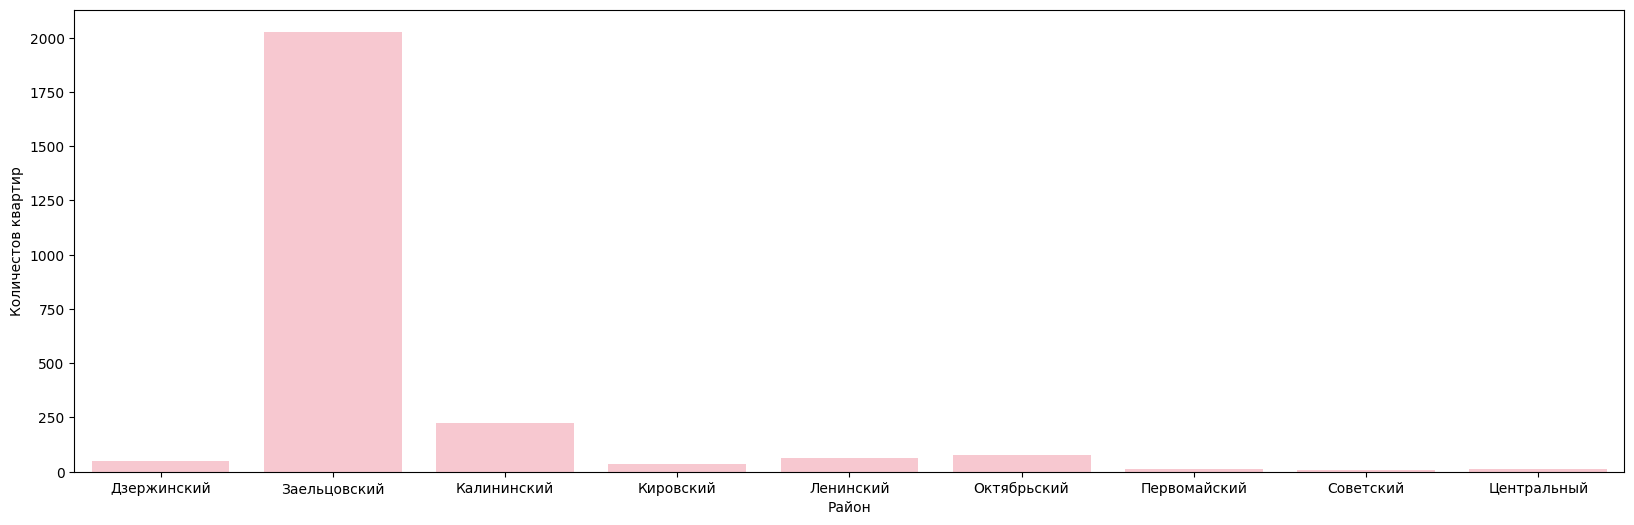

In [12]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df_new.groupby('district').count()['price']
sns.barplot(districts, color='pink')

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

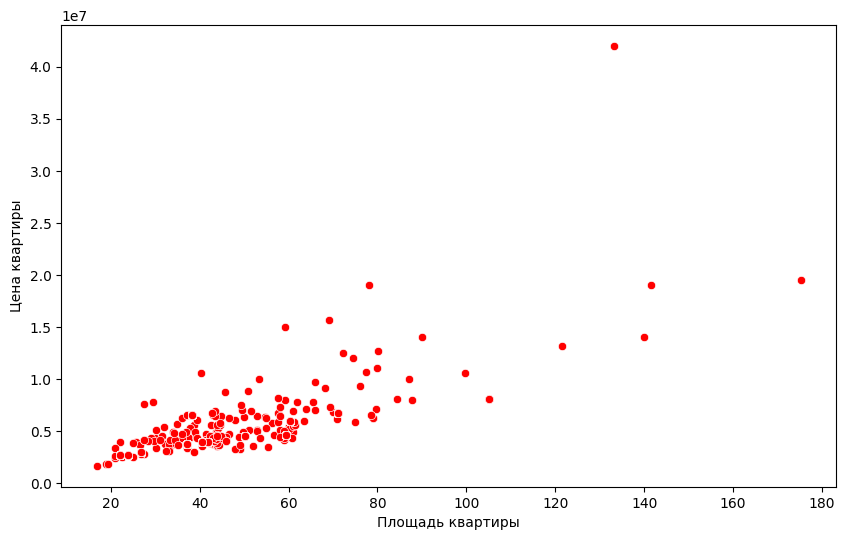

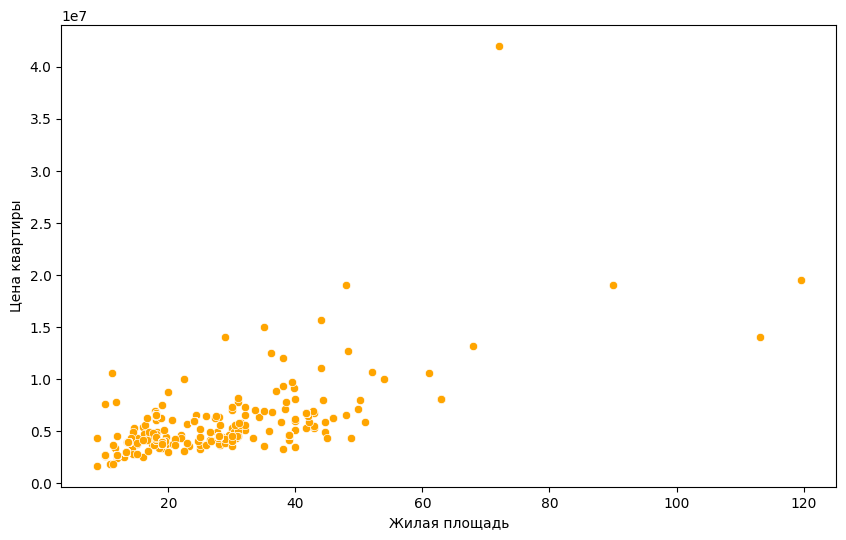

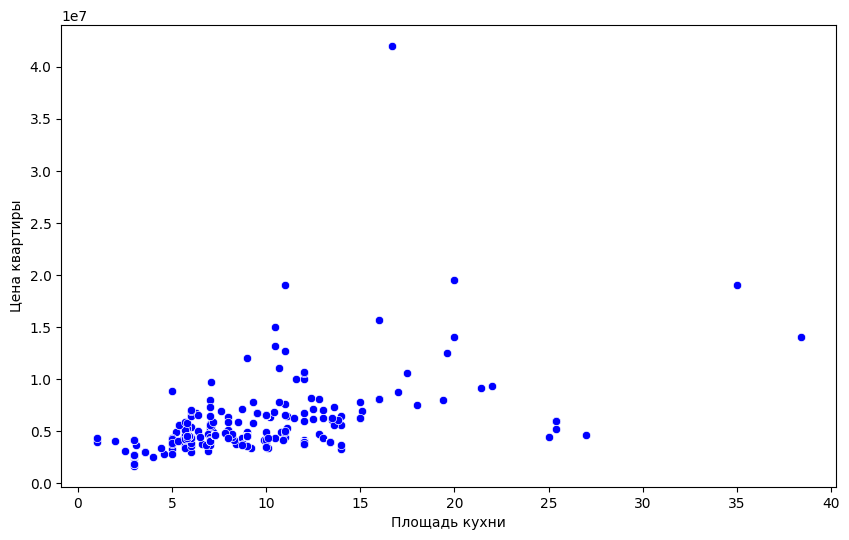

In [9]:
# EDA (old flats)

plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['total_square'], y=df_old['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['living_sq'], y=df_old['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['kitchen_sq'], y=df_old['price'], color='blue')


<Axes: xlabel='price', ylabel='Density'>

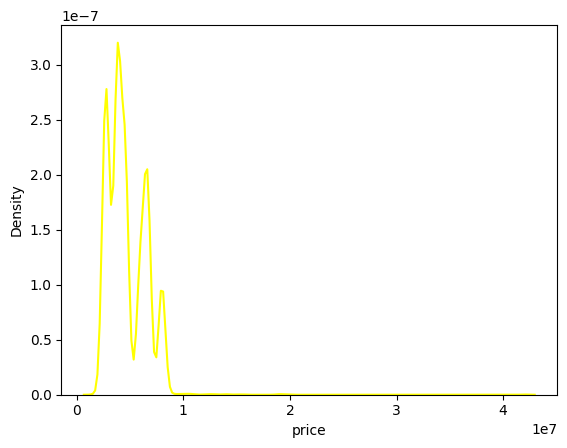

In [10]:
sns.kdeplot(df_old['price'], color='yellow')


<Axes: xlabel='total_square', ylabel='Density'>

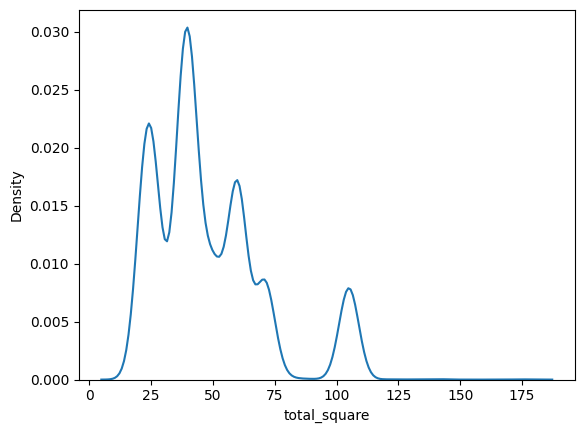

In [11]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Район', ylabel='Количестов квартир'>

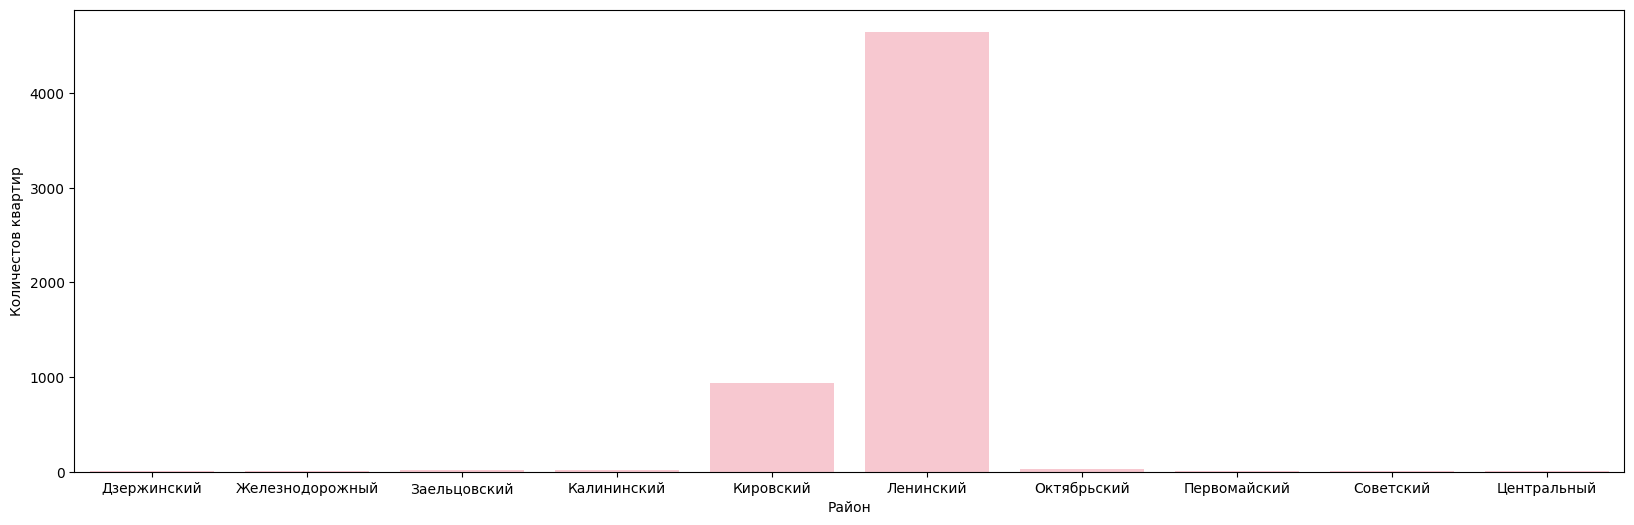

In [13]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df_old.groupby('district').count()['rented']
sns.barplot(districts, color='pink')

<Axes: xlabel='Вид из окна', ylabel='Цена квартиры'>

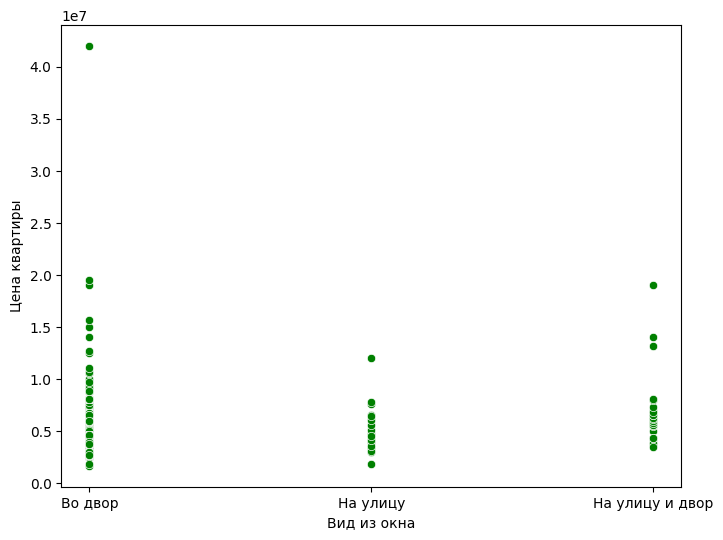

In [14]:
plt.figure(figsize=(8, 6))

plt.xlabel('Вид из окна')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['window_view'], y=df_old['price'], color='green')

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

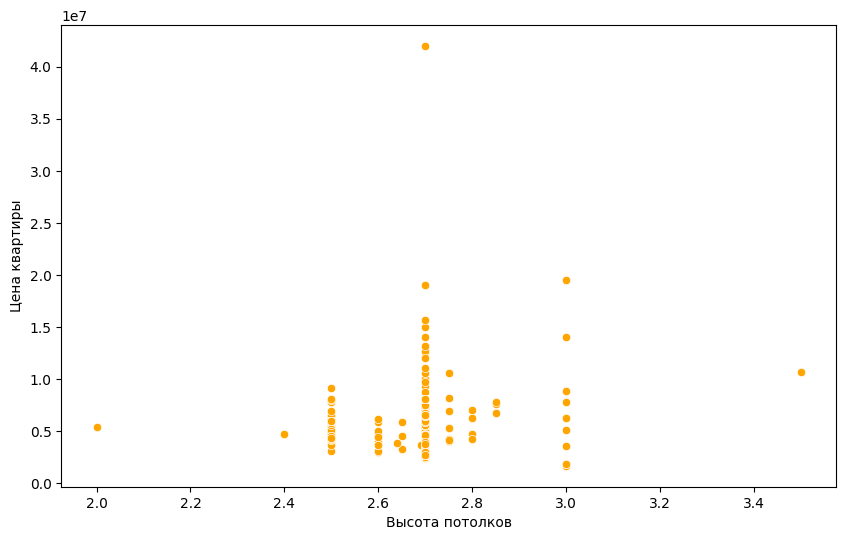

In [15]:
plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['ceil_height'], y=df_old['price'], color='orange')

In [16]:
# outliers (old flats)

for column in['total_square']:
    q1 = df_old[column].quantile(0.25)
    q3 = df_old[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_old_dummy = df_old_dummy[df_old_dummy[column].between(lower_bound, upper_bound)]
    

<Axes: xlabel='total_square', ylabel='Density'>

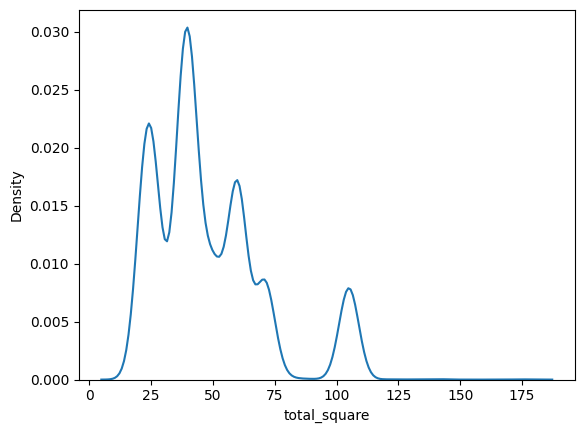

In [17]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

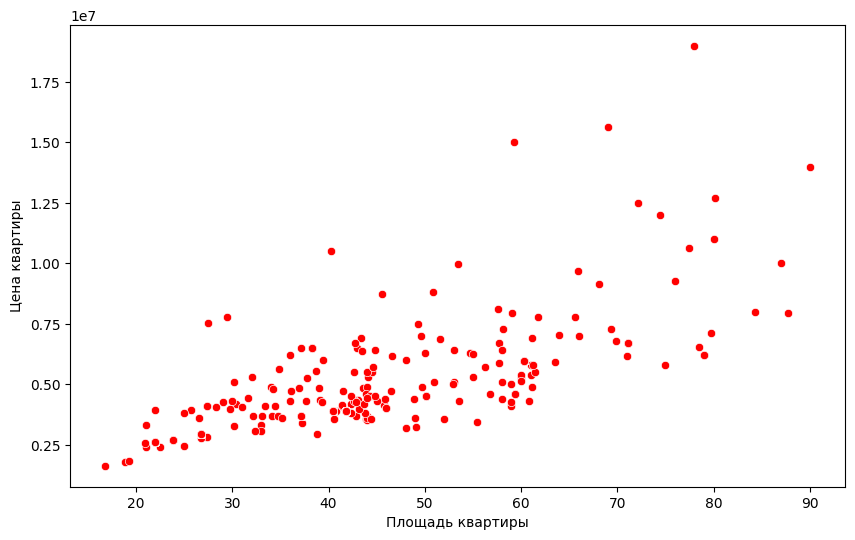

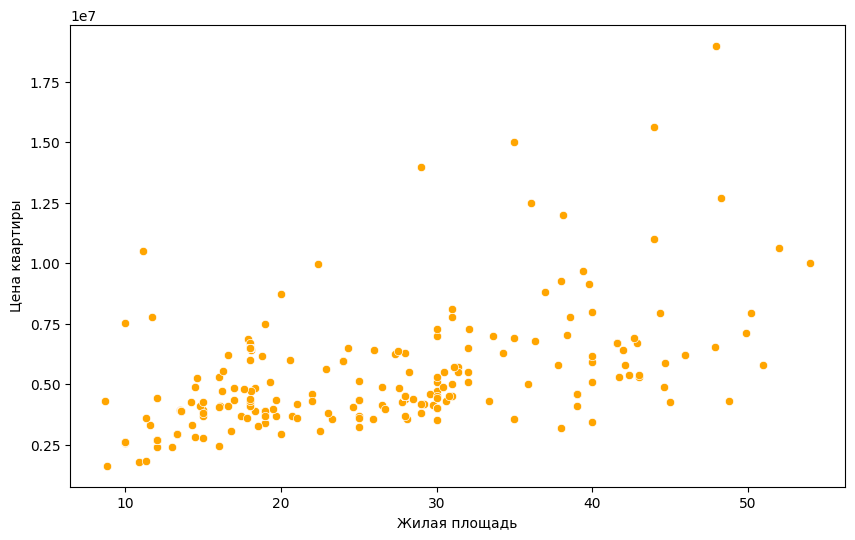

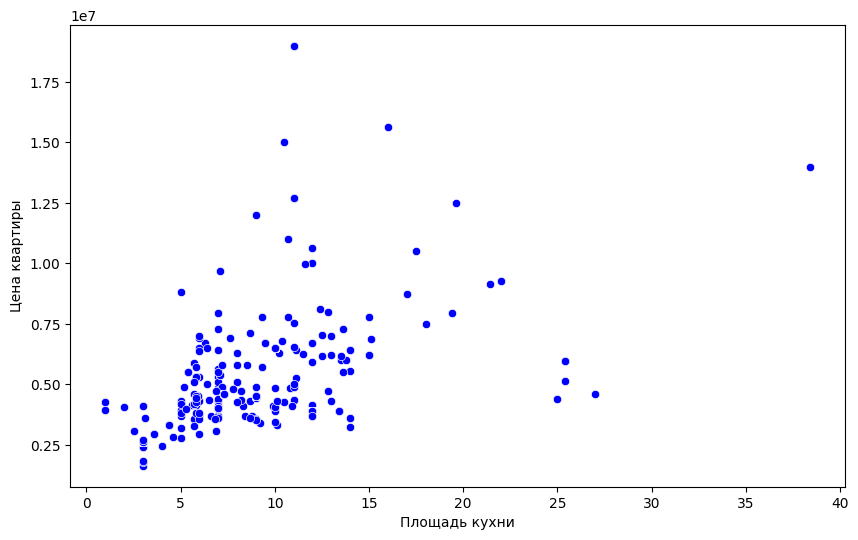

In [18]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['total_square'], y=df_old_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['living_sq'], y=df_old_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['kitchen_sq'], y=df_old_dummy['price'], color='blue')

In [19]:
model_old = CatBoostRegressor()

train, test = train_test_split(df_old_dummy, test_size=0.2, random_state=34)

x = train.drop(['price'], axis=1)
y = train['price']
model_old.fit(x, y)

Learning rate set to 0.051352
0:	learn: 1399584.9156123	total: 155ms	remaining: 2m 34s
1:	learn: 1336384.6180562	total: 157ms	remaining: 1m 18s
2:	learn: 1274796.7062184	total: 159ms	remaining: 52.7s
3:	learn: 1219302.5540697	total: 161ms	remaining: 40s
4:	learn: 1165737.9797716	total: 163ms	remaining: 32.4s
5:	learn: 1113268.2215145	total: 165ms	remaining: 27.3s
6:	learn: 1063226.5655619	total: 167ms	remaining: 23.7s
7:	learn: 1016237.5890155	total: 169ms	remaining: 21s
8:	learn: 972366.4343877	total: 171ms	remaining: 18.9s
9:	learn: 929211.4586446	total: 174ms	remaining: 17.2s
10:	learn: 889853.8233490	total: 176ms	remaining: 15.8s
11:	learn: 852580.7701607	total: 178ms	remaining: 14.7s
12:	learn: 817375.0868011	total: 181ms	remaining: 13.7s
13:	learn: 784659.9494051	total: 183ms	remaining: 12.9s
14:	learn: 753070.7565870	total: 186ms	remaining: 12.2s
15:	learn: 723307.1153075	total: 188ms	remaining: 11.6s
16:	learn: 695187.2231144	total: 190ms	remaining: 11s
17:	learn: 668259.944745

In [20]:
pred = model_old.predict(test.drop('price', axis=1))

In [22]:
mean_absolute_error(test['price'], pred)

28468.3221977418

Text(0.5, 1.0, 'Feature Importance')

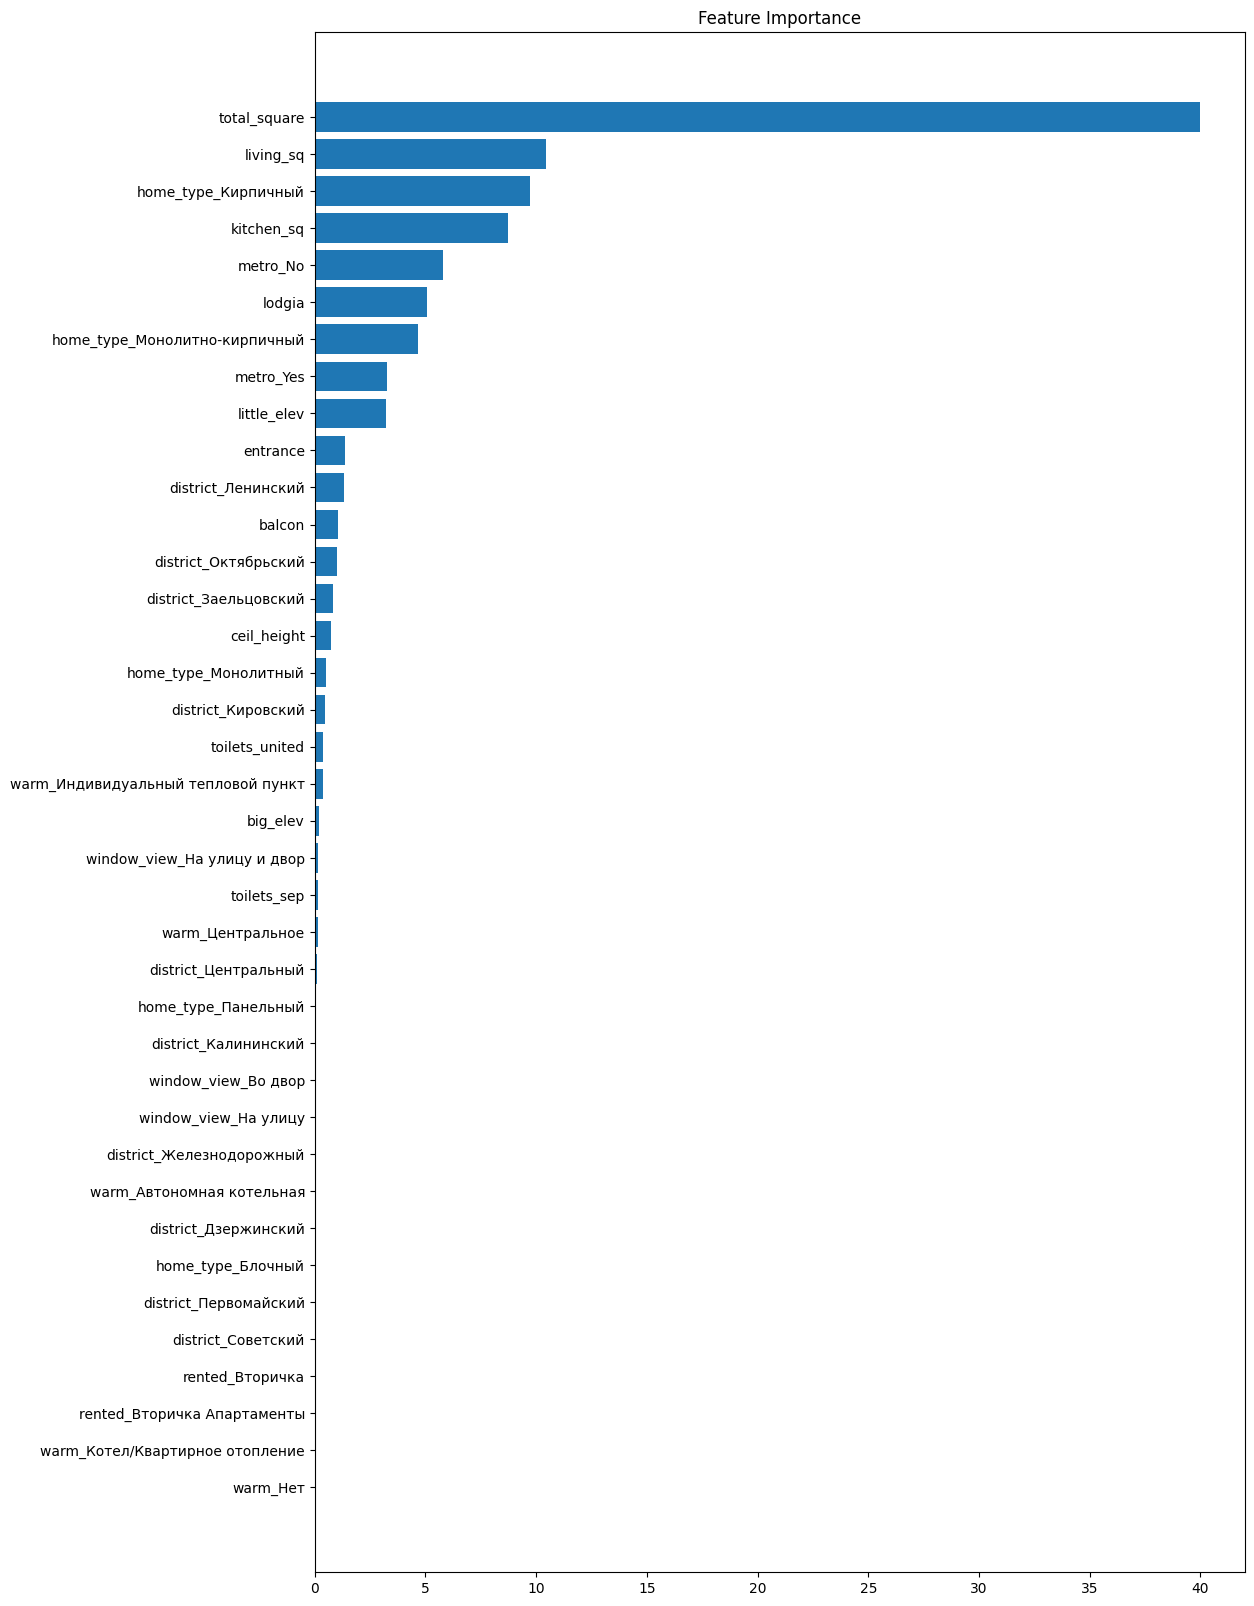

In [23]:
feature_importance = model_old.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.drop('price', axis=1).columns)[sorted_idx])
plt.title('Feature Importance')

In [26]:
# linear regression
import statsmodels.api as sm

maxpvalue = 1
n = 1
regressors = train.drop('price', axis=1).columns.to_list()

while maxpvalue > 0.05:
    x = train[regressors]
    y = train['price']
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1.astype(float)).fit()
    pv = model.pvalues.to_list()
    maxpv = max(pv[1:])
    max_index = pv.index(maxpv)
    print('Номер интерации: '+ str(n))
    print('Регрессор с максимальным p-value: '+ str(regressors[max_index-1]) + ' P-value: '+ str(maxpv))
    print('-------------------------------------------------------------')

    if maxpv > 0.05:
        regressors.pop(max_index - 1)
        maxpvalue = maxpv
        n += 1
    else:
        maxpvalue = 0

print('Итоговая модель: ')
y = train['price']
x = train[regressors]
x1 = sm.add_constant(x)
model = sm.OLS(y, x1.astype(float)).fit()
print(model.summary2())

Номер интерации: 1
Регрессор с максимальным p-value: window_view_Во двор P-value: 0.9688181407929393
-------------------------------------------------------------
Номер интерации: 2
Регрессор с максимальным p-value: home_type_Блочный P-value: 0.45824781824353733
-------------------------------------------------------------
Номер интерации: 3
Регрессор с максимальным p-value: home_type_Монолитно-кирпичный P-value: 0.7481057072126386
-------------------------------------------------------------
Номер интерации: 4
Регрессор с максимальным p-value: window_view_На улицу P-value: 0.41755515482792593
-------------------------------------------------------------
Номер интерации: 5
Регрессор с максимальным p-value: metro_Yes P-value: 0.2853807290064947
-------------------------------------------------------------
Номер интерации: 6
Регрессор с максимальным p-value: district_Советский P-value: 0.20972405902901056
-------------------------------------------------------------
Номер интерации: 7
Ре

In [36]:
test_1 = test[model.params.index.to_list()[1:]]
test_1 = sm.add_constant(test_1)
pred = model.predict(test_1)
print(pred)

13105    2.985277e+06
10580    6.475532e+06
2753     3.638110e+06
10740    6.691303e+06
10805    3.638110e+06
             ...     
3362     2.985277e+06
7280     3.971460e+06
5632     4.630322e+06
12581    2.557937e+06
5702     5.970681e+06
Length: 1049, dtype: float64


In [37]:
mean_absolute_error(test['price'], pred)

69660.04973341456

In [40]:
# RF
model_rf = RandomForestRegressor()
model_rf.fit(train.drop('price', axis=1), train['price'])
pred_rf = model_rf.predict(test.drop('price', axis=1))

In [41]:
mean_absolute_error(pred_rf, test['price'])

30325.124061010487